In [2]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

# import ROOT
# import event_processing_v4
# import postgresql_v3_event_storage
# import dataset_query_functions_v3
# import tool.npy_frames_visualization as npy_vis
# import tool.acqconv
# from data_analysis_utils import *
# from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
from tool.misc.event_analysis_record_v3_6_update import EventAnalysisRecordV3_6_update
import dataset_query_functions_v3

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [4]:
data_snippents_dir = 'ver4_flatmap_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_processing_cls.event_analysis_record_class = EventAnalysisRecordV3_6_update
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [6]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$',None), 
        'gtu_datetime_mean', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
        ('trg_box_per_gtu|trg_pmt_per_gtu|trg_ec_per_gtu|n_persist|gtu_in_persist','mean|max'),
        'orig_x_y_max', 'orig_x_y_sum',
        'trg_count_nonzero',
        
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_count',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_mean',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_max',
        '(proc|trg)\d_(x|gtu)_(x|y)_clusters_max_peak_clu_size',
        
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_peak_clu_height$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_peak_clu_width$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_phi$',
        '(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_rho$',
        '(proc|trg|alt)\d_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_phi$',
        '(proc|trg|alt)\d_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_rho$',
        
        ]
)

tot_columns = 0
for t, vl in columns_for_analysis_dict.items():
    sys.stdout.write(t)
    sys.stdout.write('\n\t- ')
    print('\n\t- '.join(vl))
    print()
    tot_columns += len(vl)
print('-'*60)
print(tot_columns)

In [11]:
current_columns_for_analysis_dict = columns_for_analysis_dict

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = ''
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
#     data_table_name_overwrite=events_data_table_name
)

In [12]:
flight_bg05_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

# Number of events per time (bgf 0.5)

In [17]:
import math
import datetime

0    1493190314.12 (2017-04-26 07:05:14.121748) 1493208314.12 (2017-04-26 12:05:14.121748) 11368  


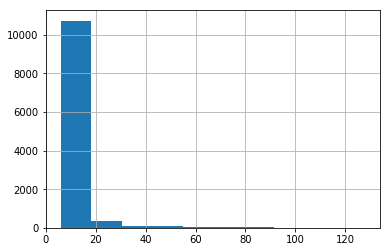

1    1493208314.12 (2017-04-26 12:05:14.121748) 1493226314.12 (2017-04-26 17:05:14.121748) 20752  


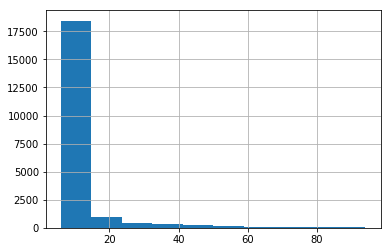

2    1493226314.12 (2017-04-26 17:05:14.121748) 1493244314.12 (2017-04-26 22:05:14.121748) 0      
3    1493244314.12 (2017-04-26 22:05:14.121748) 1493262314.12 (2017-04-27 03:05:14.121748) 0      
4    1493262314.12 (2017-04-27 03:05:14.121748) 1493280314.12 (2017-04-27 08:05:14.121748) 13329  


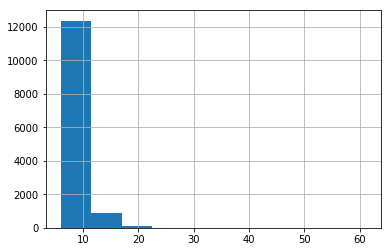

5    1493280314.12 (2017-04-27 08:05:14.121748) 1493298314.12 (2017-04-27 13:05:14.121748) 21149  


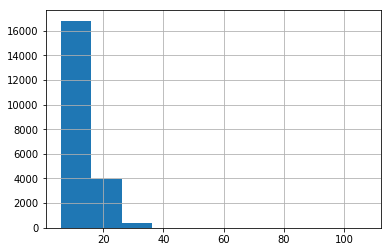

6    1493298314.12 (2017-04-27 13:05:14.121748) 1493316314.12 (2017-04-27 18:05:14.121748) 806    


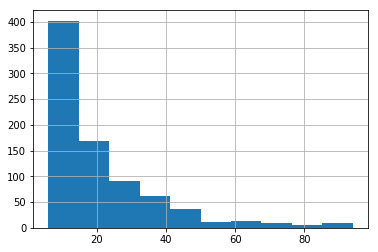

7    1493316314.12 (2017-04-27 18:05:14.121748) 1493334314.12 (2017-04-27 23:05:14.121748) 0      
8    1493334314.12 (2017-04-27 23:05:14.121748) 1493352314.12 (2017-04-28 04:05:14.121748) 0      
9    1493352314.12 (2017-04-28 04:05:14.121748) 1493370314.12 (2017-04-28 09:05:14.121748) 36950  


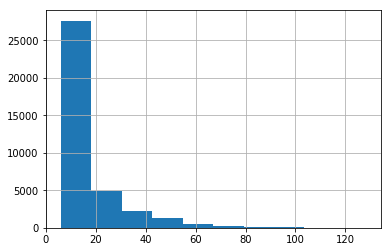

10   1493370314.12 (2017-04-28 09:05:14.121748) 1493388314.12 (2017-04-28 14:05:14.121748) 31795  


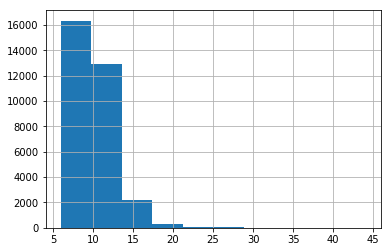

11   1493388314.12 (2017-04-28 14:05:14.121748) 1493406314.12 (2017-04-28 19:05:14.121748) 8513   


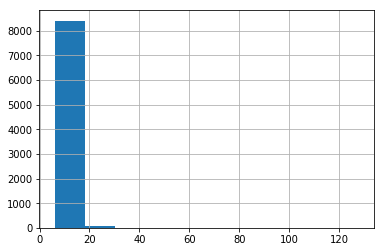

12   1493406314.12 (2017-04-28 19:05:14.121748) 1493424314.12 (2017-04-29 00:05:14.121748) 0      
13   1493424314.12 (2017-04-29 00:05:14.121748) 1493442314.12 (2017-04-29 05:05:14.121748) 1443   


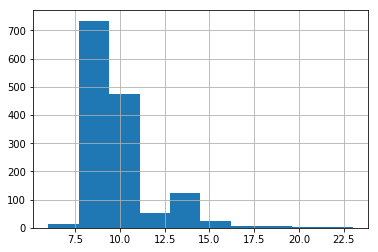

14   1493442314.12 (2017-04-29 05:05:14.121748) 1493460314.12 (2017-04-29 10:05:14.121748) 24489  


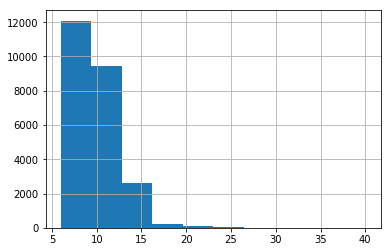

15   1493460314.12 (2017-04-29 10:05:14.121748) 1493478314.12 (2017-04-29 15:05:14.121748) 12125  


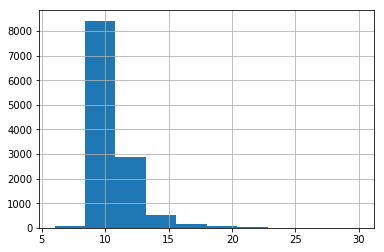

16   1493478314.12 (2017-04-29 15:05:14.121748) 1493496314.12 (2017-04-29 20:05:14.121748) 0      
17   1493496314.12 (2017-04-29 20:05:14.121748) 1493514314.12 (2017-04-30 01:05:14.121748) 0      
18   1493514314.12 (2017-04-30 01:05:14.121748) 1493532314.12 (2017-04-30 06:05:14.121748) 291    


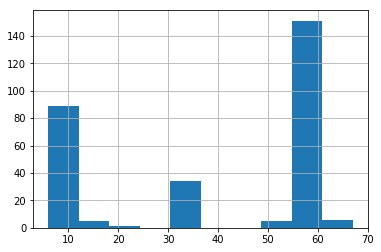

19   1493532314.12 (2017-04-30 06:05:14.121748) 1493550314.12 (2017-04-30 11:05:14.121748) 6778   


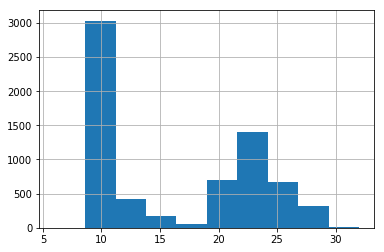

20   1493550314.12 (2017-04-30 11:05:14.121748) 1493568314.12 (2017-04-30 16:05:14.121748) 5704   


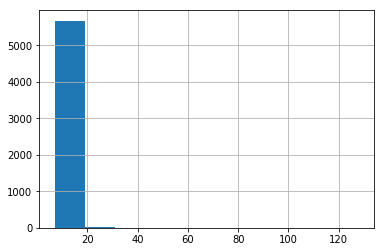

21   1493568314.12 (2017-04-30 16:05:14.121748) 1493586314.12 (2017-04-30 21:05:14.121748) 0      
22   1493586314.12 (2017-04-30 21:05:14.121748) 1493604314.12 (2017-05-01 02:05:14.121748) 0      
23   1493604314.12 (2017-05-01 02:05:14.121748) 1493622314.12 (2017-05-01 07:05:14.121748) 1107   


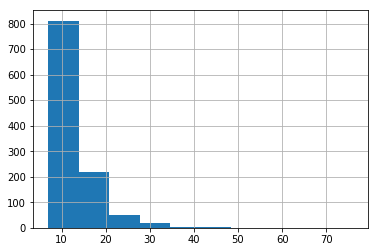

24   1493622314.12 (2017-05-01 07:05:14.121748) 1493640314.12 (2017-05-01 12:05:14.121748) 202    


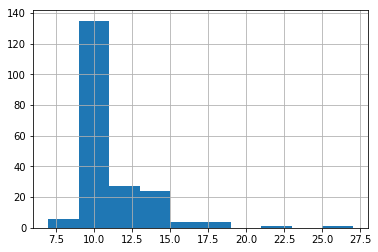

25   1493640314.12 (2017-05-01 12:05:14.121748) 1493658314.12 (2017-05-01 17:05:14.121748) 37     


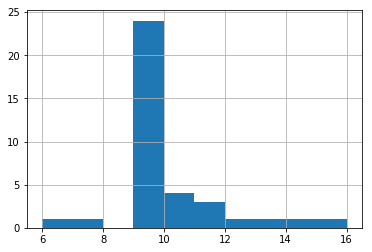

26   1493658314.12 (2017-05-01 17:05:14.121748) 1493676314.12 (2017-05-01 22:05:14.121748) 0      
27   1493676314.12 (2017-05-01 22:05:14.121748) 1493694314.12 (2017-05-02 03:05:14.121748) 0      
28   1493694314.12 (2017-05-02 03:05:14.121748) 1493712314.12 (2017-05-02 08:05:14.121748) 1281   


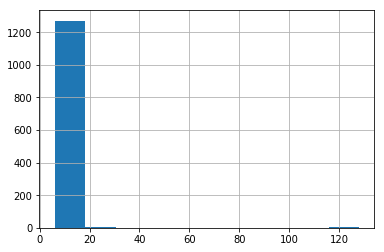

29   1493712314.12 (2017-05-02 08:05:14.121748) 1493730314.12 (2017-05-02 13:05:14.121748) 8690   


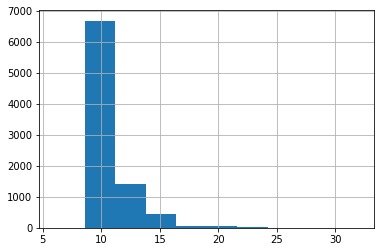

30   1493730314.12 (2017-05-02 13:05:14.121748) 1493748314.12 (2017-05-02 18:05:14.121748) 326    


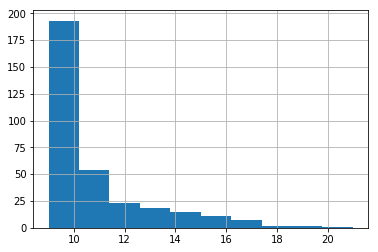

31   1493748314.12 (2017-05-02 18:05:14.121748) 1493766314.12 (2017-05-02 23:05:14.121748) 0      
32   1493766314.12 (2017-05-02 23:05:14.121748) 1493784314.12 (2017-05-03 04:05:14.121748) 0      
33   1493784314.12 (2017-05-03 04:05:14.121748) 1493802314.12 (2017-05-03 09:05:14.121748) 6587   


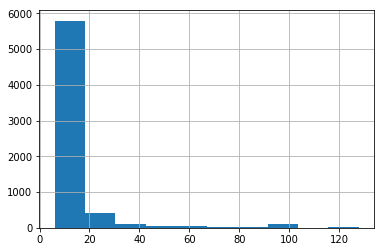

34   1493802314.12 (2017-05-03 09:05:14.121748) 1493820314.12 (2017-05-03 14:05:14.121748) 101    


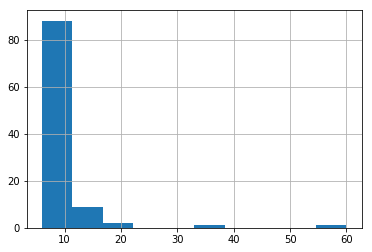

35   1493820314.12 (2017-05-03 14:05:14.121748) 1493838314.12 (2017-05-03 19:05:14.121748) 0      
36   1493838314.12 (2017-05-03 19:05:14.121748) 1493856314.12 (2017-05-04 00:05:14.121748) 0      
37   1493856314.12 (2017-05-04 00:05:14.121748) 1493874314.12 (2017-05-04 05:05:14.121748) 0      
38   1493874314.12 (2017-05-04 05:05:14.121748) 1493892314.12 (2017-05-04 10:05:14.121748) 23     


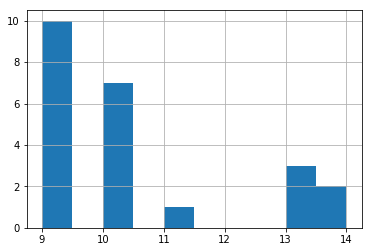

39   1493892314.12 (2017-05-04 10:05:14.121748) 1493910314.12 (2017-05-04 15:05:14.121748) 48     


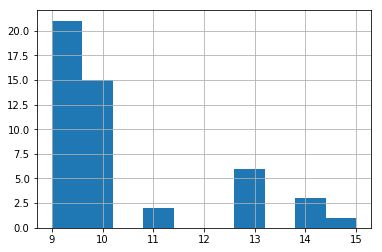

40   1493910314.12 (2017-05-04 15:05:14.121748) 1493928314.12 (2017-05-04 20:05:14.121748) 0      
41   1493928314.12 (2017-05-04 20:05:14.121748) 1493946314.12 (2017-05-05 01:05:14.121748) 0      
42   1493946314.12 (2017-05-05 01:05:14.121748) 1493964314.12 (2017-05-05 06:05:14.121748) 0      
43   1493964314.12 (2017-05-05 06:05:14.121748) 1493982314.12 (2017-05-05 11:05:14.121748) 133    


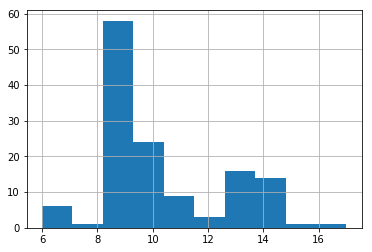

44   1493982314.12 (2017-05-05 11:05:14.121748) 1494000314.12 (2017-05-05 16:05:14.121748) 0      
45   1494000314.12 (2017-05-05 16:05:14.121748) 1494018314.12 (2017-05-05 21:05:14.121748) 0      
46   1494018314.12 (2017-05-05 21:05:14.121748) 1494036314.12 (2017-05-06 02:05:14.121748) 0      
47   1494036314.12 (2017-05-06 02:05:14.121748) 1494054314.12 (2017-05-06 07:05:14.121748) 0      
48   1494054314.12 (2017-05-06 07:05:14.121748) 1494072314.12 (2017-05-06 12:05:14.121748) 53     


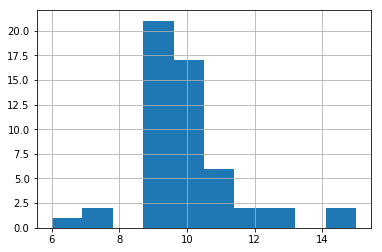

49   1494072314.12 (2017-05-06 12:05:14.121748) 1494090314.12 (2017-05-06 17:05:14.121748) 0      


In [33]:
#hist
bins_offset = flight_bg05_df.gtu_datetime_mean.min().timestamp()
bins_range_end = flight_bg05_df.gtu_datetime_mean.max().timestamp()
bin_width = 3600*5

mean_gtu_datetime_vals = []
count_entries = []

mean_num_gtu_vals = []
median_num_gtu_vals = []
quantile_025_num_gtu_vals = []
quantile_975_num_gtu_vals = []
std_num_gtu_vals = []


for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = flight_bg05_df[
        (datetime.datetime.utcfromtimestamp(min_v) <= flight_bg05_df.gtu_datetime_mean) \
        & (flight_bg05_df.gtu_datetime_mean < datetime.datetime.utcfromtimestamp(max_v))]
    
    print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} ".format(
        i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
        len(t_filtered_df)
    ))
    if len(t_filtered_df) > 0:
        mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
        count_entries.append(len(t_filtered_df))
        mean_num_gtu_vals.append(t_filtered_df.num_gtu.mean())
        median_num_gtu_vals.append(t_filtered_df.num_gtu.median())
        quantile_025_num_gtu_vals.append(t_filtered_df.num_gtu.quantile(0.025))
        quantile_975_num_gtu_vals.append(t_filtered_df.num_gtu.quantile(0.975))
        std_num_gtu_vals.append(t_filtered_df.num_gtu.std())
    
        
        t_filtered_df.num_gtu.hist()
        plt.show()
    
#     print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} {:<10.3f} {:<10.3f}".format(
#         i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
#         len(t_filtered_df), t_filtered_df.num_gtu.min(), t_filtered_df.num_gtu.max()
#     ))
    
#     if len(t_filtered_df) > 0:
#         t_filtered_df.num_gtu.hist()
#         plt.show()
        
#         mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
#         if quantile_975_num_gtu_vals[-1] > 8:
#             print('!'*30)
#             print(quantile_975_num_gtu_vals[-1])
#             print('!'*30)
#         count_num_gtu_vals.append(t_filtered_df.num_gtu.count())
                
    
# filtered_df 

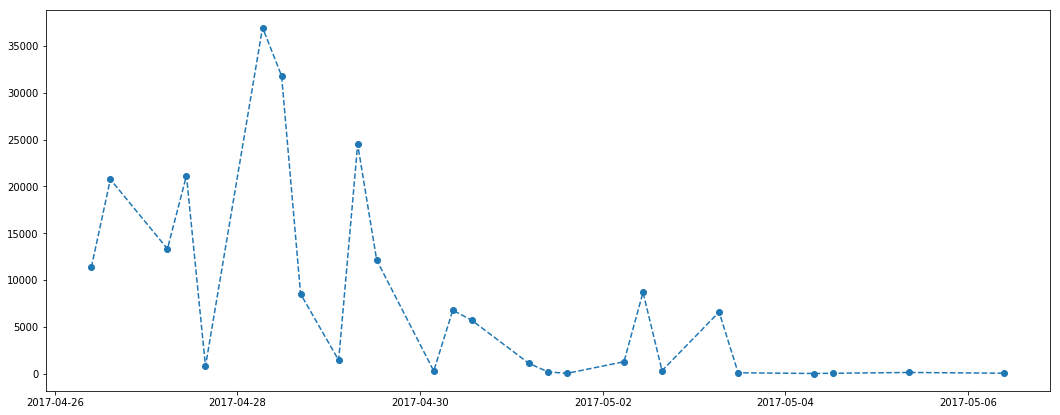

In [36]:
plt.close('all')
plt.figure(figsize=(18,7))
plt.plot(mean_gtu_datetime_vals, count_entries, marker='o', linestyle='--')
plt.show()

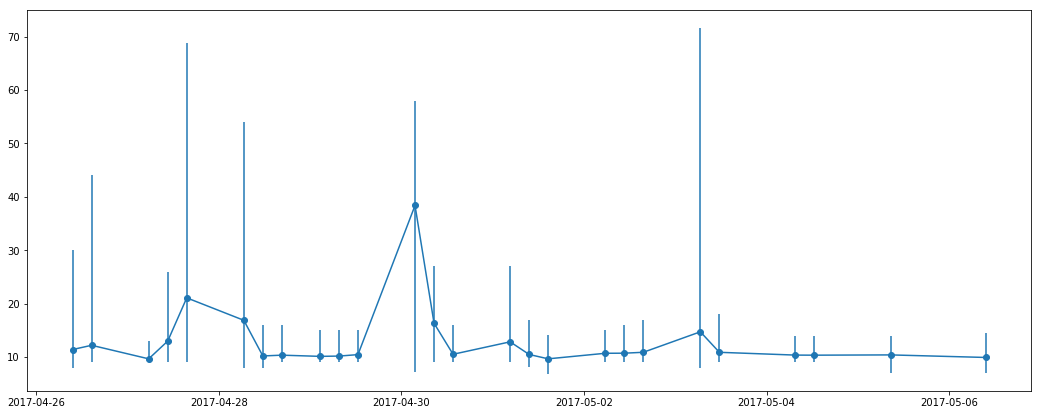

In [37]:
yerr=[np.array(mean_num_gtu_vals) - np.array(quantile_025_num_gtu_vals), 
      np.array(quantile_975_num_gtu_vals) - np.array(mean_num_gtu_vals)]
plt.figure(figsize=(18,7))
plt.errorbar(mean_gtu_datetime_vals, mean_num_gtu_vals, marker='o', yerr=yerr)
plt.show()

In [1]:
# Number of events by duration (bgf 0.5) 

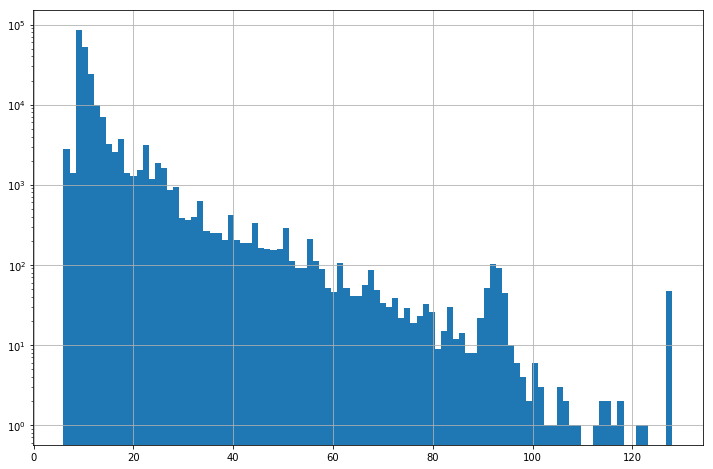

10.0
12.316302316890882


In [40]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_bg05_df #flight_data_df[flight_data_df.bg_size < 20]
h = filtered_df.num_gtu.hist(bins=100, figsize=(12,8))
h.set_yscale('log')
plt.show()
print(np.median(filtered_df.num_gtu))
print(np.mean(filtered_df.num_gtu))

In [ ]:
## Length distribution

In [ ]:
## Long events by date

In [ ]:
# Number of events by background (bgf 0.5)

In [ ]:
## By date (from ver4)